## MNIST autoencoder with transfer learning

This workbook demonstrates how to build and train a PyTorch model to "transcribe" MNIST digits into a different font: Given an MNIST digit as input, the network outputs the same digit in a typewriter font. Note that this is mostly an academic exercise and likely not super useful in reality; I put this together as my first experiment with the PyTorch framework in order to learn how to implement transfer learning in PyTorch.

The source code for the model is in [autoencoder.py](autoencoder.py) and for the standard PyTorch training loop in [trainer.py](trainer.py).

The model is taken from [pytorch-beginner](https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py) and adapted for transfer learning: we first train a digit *classifier* with the encoder portion of the network, and then train the decoder portion of the network (without adjusting any of the encoder weights) w.r.t. handcrafted digit labels (see [data/digits](data/digits)) with a different font.

In [27]:
# Load data

import torch
import torchvision
from torchvision import transforms
import digits_dataset

transform = torchvision.transforms.Compose(
    [
    transforms.Resize((28, 28)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# The standard MNIST dataset with handwritten digits plus labels.
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True)

# The digit training set is used to train the encoder portion of the network.
label_transform = lambda l: l  # We'll use the label_transform further down.
digit_trainset = digits_dataset.MnistWithPrintWriterLabels(trainset, 
                                            "./data/digits",
                                            digit_transform=transform,
                                                          label_transform=lambda l: label_transform(l))
digit_trainset_loader = torch.utils.data.DataLoader(digit_trainset, batch_size=5,
                                                    shuffle=True)

# Test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

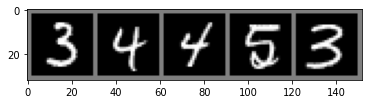

tensor(3) tensor(4) tensor(4) tensor(5) tensor(3)


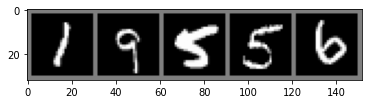

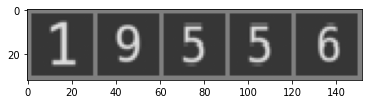

In [28]:
# Show some sample MNIST digits, corresponding labels, and target font digits.

from util import imshow


images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j] for j in range(5)))

images, digits = iter(digit_trainset_loader).next()
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(digits))

In [29]:
# Define network

from autoencoder import Net
net = Net()
print(net)

Net(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
  )
  (unclassifier): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)


In [30]:
# Train encoder

import torch.optim as optim
import torch.nn as nn
from trainer import train

# The Net::set_train_encoder function returns the set of parameters
# in the encoder portion of the network. We pass those parameters to the
# optimizer
params = net.set_train_encoder()
optimizer = optim.SGD(params, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(net, train_loader, optimizer, criterion, 1)

[1,  2000] loss: 1.395
[1,  4000] loss: 0.498
[1,  6000] loss: 0.394
[1,  8000] loss: 0.348
[1, 10000] loss: 0.338
[1, 12000] loss: 0.307
Finished Training


In [38]:
# Train decoder

# Important: Only pass those parameters to the optimizer that should get updated.
# The optimizer will change weights unless the gradient is 'None', i.e., the
# interaction between the optimizer and require_grad is not so obvious. Alternatively,
# we could set the encoder weights to None explicitly in Net::set_train_decoder,
# but that seems more of a hack.
# Compare https://github.com/pytorch/pytorch/blob/master/torch/optim/adam.py#L62
params = net.set_train_decoder()
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
train(net, digit_trainset_loader, optimizer, criterion, 1)

[1,  2000] loss: 0.015
[1,  4000] loss: 0.015
[1,  6000] loss: 0.015
[1,  8000] loss: 0.014
[1, 10000] loss: 0.014
[1, 12000] loss: 0.014
Finished Training


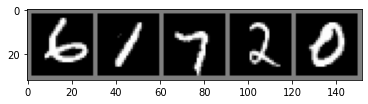

GroundTruth:  tensor(6) tensor(1) tensor(7) tensor(2) tensor(0)
Predicted by encoder portion of network:  tensor(6) tensor(1) tensor(7) tensor(2) tensor(0)


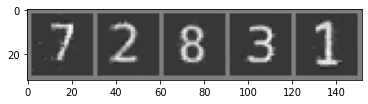

In [37]:
# Test network

images, labels = iter(train_loader).next()

# Display input test images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(len(images))))

# Test encoder portion of the network
net.set_eval_encoder()
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted by encoder portion of network: ', ' '.join('%5s' % predicted[j] for j in range(len(images))))

# Test decoder portion of the network
net.set_eval_decoder()
outputs = net(images)
imshow(torchvision.utils.make_grid(outputs))

At this point it seems pretty clear that the decoder network could learn to render any font. Clearly, it could also learn to render different digits, for instance it could increment the given input image. We show below that we can retrain the decoder network to render the input image plus 1 (modulo 10).

When you think about this for the very first time, you may be a little confused: if the encoder learns to recognize a single digit, would it be pretty hard for the decoder to learn to render a completely different digit? The answer is quite obvious: the 10 neurons at the end of the encoder have no knowledge of the digit they represent, and so the subsequent decoder network can render them as it pleases.

It's also worth consider a simple information theoretical perspective: how can the network possible render a full 28x28 pixel version of the 4 bit 0..9 digit represented by the middle layer of the network? Well, the 28x28 pixel representations are not encoded in the intermediate classifier, but in the weights of the decoder network. Back-of-the-envolope: 10 grey-scale (== 1 byte per pixel) images with 28x28 pixels need 10*28*28 = 7840 bytes; the decoder network has 6411 float parameters, i.e., 25644 bytes and thus about four times more "information capacity" to represent 10 digits.

In [34]:
# Determine the number of parameters of the decoder network

params = net.set_train_decoder()
print("Number of float weights in decoder network:", sum(p.numel() for p in net.parameters()))

Number of float weights in decoder network: 6411


In [35]:
# Retrain the decoder to render ((input + 1) mod 10).

label_transform = lambda l: (int(l) + 1) % 10
params = net.set_train_decoder()
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
train(net, digit_trainset_loader, optimizer, criterion, 1)

[1,  2000] loss: 0.030
[1,  4000] loss: 0.020
[1,  6000] loss: 0.019
[1,  8000] loss: 0.018
[1, 10000] loss: 0.017
[1, 12000] loss: 0.016
Finished Training


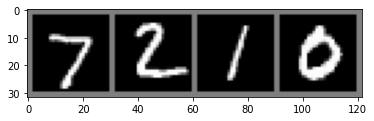

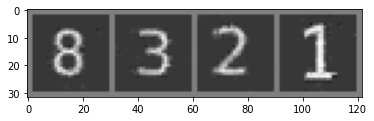

In [36]:
# Visualize re-trained decoder

images, labels = iter(test_loader).next()
imshow(torchvision.utils.make_grid(images))
net.set_eval_decoder()
outputs = net(images)
imshow(torchvision.utils.make_grid(outputs))